In [11]:
using Pkg
Pkg.add(["Plots","CSV","DataFrames","StatsPlots","Statistics","GLM"])
Pkg.add(["StateSpaceModels","LinearAlgebra"])
Pkg.add("ARCHModels")
Pkg.add("HypothesisTests")


   Resolving package versions...
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Manifest.toml`
┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
│   FilePathsBaseMmapExt [968c5e7e-8fc3-5f0f-93d2-8a5e0e125e4f]
│   FilePathsBaseTestExt [36f6b4e4-024d-52bd-a01f-148eb20c09de]
└ @ Pkg.API C:\Users\bowus\AppData\Local\Programs\Julia-1.10.5\share\julia\stdlib\v1.10\Pkg\src\API.jl:1279
   Resolving package versions...
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Manifest.toml`
┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
│   FilePathsBaseMmapExt [968c5e7e-8fc3-5f0f-93d2-8a5e0e125e4f]
│   FilePathsBaseTestExt [36f6b4e4-024d-52bd-a01f-148eb20c09de]
└ @ Pkg.API C:\Users\bowus\AppDa

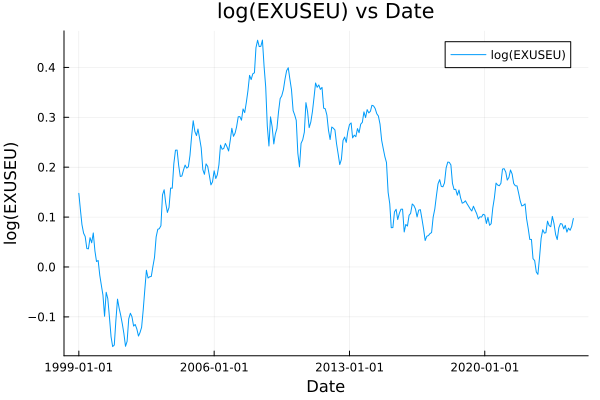

In [12]:
using CSV, DataFrames, StatsPlots, GLM
df = CSV.read("EXUSEU.csv", DataFrame)
df.log_EXUSEU = log.(df.EXUSEU)
first(df, 5)
plot(df.DATE, df.log_EXUSEU, label="log(EXUSEU)", xlabel="Date", ylabel="log(EXUSEU)", title="log(EXUSEU) vs Date", fmt=:png)

In [15]:
using ARCHModels, LinearAlgebra
function select_best_arma_bic(y, pmax, qmax)
    # Function to calculate BIC
    function calculate_bic(model, y, p, q)
        n = length(y)
        k = p + q + 1  # p lags + q lags + 1 for the intercept
        llf = loglikelihood(model)  # Log-likelihood function
        bic = -2 * llf + log(n) * k
        return bic
    end

    # Initialize arrays to store BIC values and corresponding (p, q) pairs
    bic_values = []
    pq_combinations = []

    # Loop through all combinations of p and q
    for p in 0:pmax
        for q in 0:qmax
            try
                # Fit the ARMA(p, q) model
                model = fit(ARMA{p,q}, y)
                
                # Calculate the BIC
                bic = calculate_bic(model, y, p, q)
                
                # Store the BIC and the corresponding (p, q)
                push!(bic_values, bic)
                push!(pq_combinations, (p, q))
            catch e
                println("Model ARMA($p,$q) failed with error: $e")
            end
        end
    end

    # Find the index of the minimum BIC
    min_index = argmin(bic_values)

    # Retrieve the corresponding (p, q) combination
    optimal_p, optimal_q = pq_combinations[min_index]

    # Return the optimal (p, q) combination and the corresponding model
    return optimal_p, optimal_q , pq_combinations[min_index], bic_values[min_index]
end
select_best_arma_bic(df.log_EXUSEU, 4, 4)

(1, 1, (1, 1), -1496.9430140732643)

In [16]:
(p,q,_,_) = select_best_arma_bic(df.log_EXUSEU, 5, 5)
opt_model = fit(ARMA{p,q}, df.log_EXUSEU)
println(opt_model)


TGARCH{0, 0, 0} model with Gaussian errors, T=308.

Mean equation parameters:
──────────────────────────────────────────────
      Estimate   Std.Error   z value  Pr(>|z|)
──────────────────────────────────────────────
c   0.00317336  0.00260903   1.2163     0.2239
φ₁  0.979333    0.013225    74.0516     <1e-99
θ₁  0.316292    0.0458835    6.89337    <1e-11
──────────────────────────────────────────────

Volatility parameters:
─────────────────────────────────────────────
      Estimate   Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────────
ω  0.000429068  3.91274e-5  10.9659    <1e-27
─────────────────────────────────────────────



Question (b): Compute one, two and three steps ahead forecast for the exchange rate
 using your model in (a).

In [21]:
y = df.log_EXUSEU
opt_model = fit(ARMA{p,q}, df.log_EXUSEU)
coefficients = coef(opt_model)
mu = coefficients[1]
ar_params = coefficients[2:p+1]
ma_params = coefficients[p+2:end]
resid = residuals(opt_model)    # Get the residuals
# Manual Forecast Computation (1, 2, and 3 steps ahead)
n = length(df.log_EXUSEU)  # Last index of the observed series

# Initialize forecast array
forecasts = []

# Compute one step ahead forecast
forecast_1_step = mu
if p > 0
    forecast_1_step += sum(ar_params .* reverse(y[n-p+1:n]))  # AR part
end
if q > 0
    forecast_1_step += sum(ma_params .* reverse(resid[n-q+1:n]))  # MA part
end
push!(forecasts, forecast_1_step)


forecast_2_step = mu
if p > 0
    forecast_2_step += sum(ar_params[1:min(p, 1)] .* reverse([y[n-p+2:n]; forecast_1_step]))  # AR part
end
if q > 0
    forecast_2_step += sum(ma_params[2:end] .* reverse(resid[n-q+2:n]))  # MA part
end
push!(forecasts, forecast_2_step)

# Compute three-step-ahead forecast
forecast_3_step = mu
if p > 0
    # Use forecast_1_step and forecast_2_step for the AR part
    forecast_3_step += sum(ar_params[1:min(p, 2)] .* reverse([y[n-p+3:n]; forecast_1_step; forecast_2_step]))  # AR part
end
if q > 0
    # MA part uses past residuals up to known values; future residuals assumed zero
    forecast_3_step += sum(ma_params[3:end] .* reverse(resid[n-q+3:n]))  # Past residuals
end
push!(forecasts, forecast_3_step)


# Print the forecasts
println("One step ahead forecast: ", forecasts[1])
println("Two steps ahead forecast: ", forecasts[2])
println("Three steps ahead forecast: ", forecasts[3])

One step ahead forecast: 0.7154224734429969
Two steps ahead forecast: 0.0026993594943860947
Three steps ahead forecast: 0.002707925526586085


In [23]:
using ARCHModels
function forecast_my(p, q, h_step, y)
    # Fit the ARMA(p,q) model to the data y
    opt_model = fit(ARMA{p, q}, y)
    coefficients = coef(opt_model)
    
    # Extract the model parameters
    mu = coefficients[1]  # Intercept (mean)
    ar_params = coefficients[2:p+1]  # AR coefficients
    ma_params = coefficients[p+2:end]  # MA coefficients
    resid = residuals(opt_model)  # Get the residuals (shocks)
    
    # Last index of the observed series
    n = length(y)
    
    # Initialize forecast array
    forecasts = []
    
    # Compute forecasts iteratively from 1 to h_step
    for h in 1:h_step
        forecast_h_step = mu
        
        # AR part: Use available actual data and previous forecasts
        if p > 0
            ar_terms = y[max(1, n-p+h):n]  # AR part from actual data
            ar_terms = [ar_terms; forecasts[1:min(h-1, p)]]  # Append previous forecasts for h-step > 1
            forecast_h_step += sum(ar_params[1:min(p, h)] .* reverse(ar_terms))
        end
        
        # MA part: Use residuals from available data
        if q > 0
            if h == 1
                # For 1-step-ahead forecast, use residuals directly
                forecast_h_step += sum(ma_params .* reverse(resid[n-q+1:n]))
            else
                # For h-step forecasts, assume future residuals to be zero
                ma_terms = resid[max(1, n-q+h):n]
                forecast_h_step += sum(ma_params[h:end] .* reverse(ma_terms))
            end
        end
        
        # Store the forecast
        push!(forecasts, forecast_h_step)
    end
    # Create a DataFrame to store the forecasted values
    df_forecasts = DataFrame(Step = 1:h_step, Forecast = forecasts)
    
    return df_forecasts
end
forecasetd = forecast_my(p, q, 3, df.log_EXUSEU)


,Step,Forecast
,Int64,Any
1,1,0.715422
2,2,0.00269936
3,3,0.00269936


QUESTION c: Run a regression of Yt on Y_{t-1}

In [59]:
using GLM
# Function to create lagged variables
function create_lag_matrix(y, p)
    n = length(y)
    X = hcat([y[i:n-p+i-1] for i in 1:p]...)  # Create lagged variables
    return X
end
y = df.log_EXUSEU
p = 1

X = create_lag_matrix(y, p)
    X = hcat(ones(size(X, 1)), X)  # Add intercept term
    y = y[p+1:end]  # Adjust y to match the lagged X
    
    # Fit the AR model using OLS
    model = lm(X, y)
    println(model)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
─────────────────────────────────────────────────────────────────────
         Coef.  Std. Error       t  Pr(>|t|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────
x1  0.00195433  0.00196396    1.00    0.3205  -0.00191029  0.00581896
x2  0.986909    0.00936303  105.40    <1e-99   0.968485    1.00533
─────────────────────────────────────────────────────────────────────



 Test the data for a unit root. Choose carefully which test to use and
 which option. Defend your choices and comment on the results.

In [67]:

using HypothesisTests
# Conduct the ADF test on the log of GDP series
# Perform ADF test on log_gdp_series with no constant and 1 lag
result = ADFTest(y,:trend, 1)  # Modify `:nc` and lag as needed

# Print the result
println(result)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.0172752

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.6454

Details:
    sample size in regression:          305
    number of lags:                     1
    ADF statistic:                      -1.91772
    Critical values at 1%, 5%, and 10%: [-3.98857 -3.42489 -3.13551]



GotoFREDdatabase and download the dollar to euro exchange rate at daily frequency. Estimate the best ARMA model for the daily exchange rate. How does this model compare with the model for the monthly data? Comment.

In [38]:
using CSV, DataFrames, ARCHModels
df1 = CSV.read("DEXUSEU.csv", DataFrame)
# Check if DEXUSEU column can be parsed as a Float64 and filter out non-numeric rows
df1 = filter(row -> tryparse(Float64, row.DEXUSEU) !== nothing, df1)

# Convert the DEXUSEU column to Float64
df1.DEXUSEU = parse.(Float64, df1.DEXUSEU)
df1.log_DEXUSEU = log.(df1.DEXUSEU)
select_best_arma_bic(df1.log_DEXUSEU, 4, 4)
(p,q,_,_) = select_best_arma_bic(df1.log_DEXUSEU, 5, 5)
opt_model = fit(ARMA{p,q}, df1.log_DEXUSEU)
println(opt_model)
println(p,q)


TGARCH{0, 0, 0} model with Gaussian errors, T=1250.

Mean equation parameters:
─────────────────────────────────────────────────
       Estimate    Std.Error    z value  Pr(>|z|)
─────────────────────────────────────────────────
c   0.000435259  0.000363129    1.19864    0.2307
φ₁  0.995934     0.00288781   344.876      <1e-99
─────────────────────────────────────────────────

Volatility parameters:
────────────────────────────────────────────
     Estimate   Std.Error  z value  Pr(>|z|)
────────────────────────────────────────────
ω  2.14597e-5  1.13775e-6  18.8615    <1e-78
────────────────────────────────────────────

10


In [39]:
select_best_arma_bic(df1.log_DEXUSEU, 4, 4)


(1, 0, (1, 0), -9875.056803052406)

In [37]:
Daily_forecast = forecast_my(p, q, 3, df1.log_DEXUSEU)

,Step,Forecast
,Int64,Any
1,1,6.91908e-5
2,2,2.14899e-5
3,3,2.14899e-5
